# Online Retail Clustering

## Table of Contents
- [Data Overview  and Preparation](#Data-Overview-and-Preparation)
- [Data Cleaning](#Data-Cleaning)
- [Feature Engineering and EDA](#Feature-Engineering-and-EDA)
- [Model Building](#Model-Building)
- [Business Insights and Recommendations](#Business-Insights-and-Recommendations)

## Introduction

This project uses a dataset sourced from [UCI](https://archive.ics.uci.edu/dataset/352/online+retail).

## Dataset Overview
This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

* **InvoiceNo**:	a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation
* **StockCode**:	a 5-digit integral number uniquely assigned to each distinct product
* **Description**:	product name
* **Quantity**:		the quantities of each product (item) per transaction
* **InvoiceDate**:	the day and time when each transaction was generated
* **UnitPrice**:	product price per unit	sterling
* **CustomerID**:	a 5-digit integral number uniquely assigned to each customer
* **Country**:		the name of the country where each customer resides

## Objective
To perform RFM clustering

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

pd.set_option("display.max_columns", None)
plt.rcParams['figure.dpi'] = 75

from IPython.display import display, HTML
display(HTML("<style>.container {width:100% !important}</style>"))

In [2]:
df = pd.read_csv('Online Retail.csv', encoding='unicode_escape')

## Data Overview and Preparation

In [3]:
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
# Checking for duplicates
df.duplicated().sum()

5268

In [5]:
df = df.drop_duplicates()
df.reset_index(drop=True, inplace=True)
df.shape

(536641, 8)

In [6]:
# Lowercase column names, rename, and reorder for easier manipulation
df.columns = df.columns.str.lower()

df.rename(columns={'invoiceno': 'invoice',
                   'stockcode': 'sku',
                   'quantity': 'units',
                   'invoicedate': 'date',
                   'unitprice': 'price'}, inplace=True)

df = df[['country', 'customerid', 'invoice', 'date', 'sku', 'description', 'price', 'units']]
df.head()

,country,customerid,invoice,date,sku,description,price,units
0,United Kingdom,17850.0,536365,12/1/2010 8:26,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55,6
1,United Kingdom,17850.0,536365,12/1/2010 8:26,71053,WHITE METAL LANTERN,3.39,6
2,United Kingdom,17850.0,536365,12/1/2010 8:26,84406B,CREAM CUPID HEARTS COAT HANGER,2.75,8
3,United Kingdom,17850.0,536365,12/1/2010 8:26,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.39,6
4,United Kingdom,17850.0,536365,12/1/2010 8:26,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.39,6


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536641 entries, 0 to 536640
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      536641 non-null  object 
 1   customerid   401604 non-null  float64
 2   invoice      536641 non-null  object 
 3   date         536641 non-null  object 
 4   sku          536641 non-null  object 
 5   description  535187 non-null  object 
 6   price        536641 non-null  float64
 7   units        536641 non-null  int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 32.8+ MB


In [8]:
# Convert date to datetime and remove hours and minutes
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.normalize()

In [9]:
round(df.describe())

,customerid,date,price,units
count,401604.0,536641,536641.0,536641.0
mean,15281.0,2011-07-03 19:22:27.938006784,5.0,10.0
min,12346.0,2010-12-01 00:00:00,-11062.0,-80995.0
25%,13939.0,2011-03-28 00:00:00,1.0,1.0
50%,15145.0,2011-07-19 00:00:00,2.0,3.0
75%,16784.0,2011-10-18 00:00:00,4.0,10.0
max,18287.0,2011-12-09 00:00:00,38970.0,80995.0
std,1714.0,NaN,97.0,219.0


Some extreme outliers in units and price

In [10]:
df.describe(include='object')

,country,invoice,sku,description
count,536641,536641,536641,535187
unique,38,25900,4070,4223
top,United Kingdom,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER
freq,490300,1114,2301,2357


In [11]:
# Checking missing values
df.isnull().sum()[df.isnull().sum() > 0]

customerid     135037
description      1454
dtype: int64

## Data Cleaning

In [12]:
# Looking at outlier units
df.loc[df['units'] >= 80995]

,country,customerid,invoice,date,sku,description,price,units
535160,United Kingdom,16446.0,581483,2011-12-09,23843,"PAPER CRAFT , LITTLE BIRDIE",2.08,80995


In [13]:
df.loc[df['customerid'] == 16446]

,country,customerid,invoice,date,sku,description,price,units
192721,United Kingdom,16446.0,553573,2011-05-18,22980,PANTRY SCRUBBING BRUSH,1.65,1
192722,United Kingdom,16446.0,553573,2011-05-18,22982,PANTRY PASTRY BRUSH,1.25,1
535160,United Kingdom,16446.0,581483,2011-12-09,23843,"PAPER CRAFT , LITTLE BIRDIE",2.08,80995
535161,United Kingdom,16446.0,C581484,2011-12-09,23843,"PAPER CRAFT , LITTLE BIRDIE",2.08,-80995


This item was cancelled, as indicated by the data dictionary for invoices beginning with "C"

In [14]:
# Adding column for absolute units to subset cancellations
df['abs_units'] = df['units'].abs()
df.loc[df['customerid'] == 16446]

,country,customerid,invoice,date,sku,description,price,units,abs_units
192721,United Kingdom,16446.0,553573,2011-05-18,22980,PANTRY SCRUBBING BRUSH,1.65,1,1
192722,United Kingdom,16446.0,553573,2011-05-18,22982,PANTRY PASTRY BRUSH,1.25,1,1
535160,United Kingdom,16446.0,581483,2011-12-09,23843,"PAPER CRAFT , LITTLE BIRDIE",2.08,80995,80995
535161,United Kingdom,16446.0,C581484,2011-12-09,23843,"PAPER CRAFT , LITTLE BIRDIE",2.08,-80995,80995


In [15]:
# Creating dataframe with cancellations and their original orders
returns = df[df.duplicated(subset=['customerid', 'date', 'sku', 'price', 'abs_units'], keep=False)]
returns.loc[returns['customerid'] == 16446]

,country,customerid,invoice,date,sku,description,price,units,abs_units
535160,United Kingdom,16446.0,581483,2011-12-09,23843,"PAPER CRAFT , LITTLE BIRDIE",2.08,80995,80995
535161,United Kingdom,16446.0,C581484,2011-12-09,23843,"PAPER CRAFT , LITTLE BIRDIE",2.08,-80995,80995


In [16]:
# Removing cancellations from main dataset and validating 
no_returns = df.drop(returns.index)
no_returns.loc[no_returns['customerid'] == 16446]

,country,customerid,invoice,date,sku,description,price,units,abs_units
192721,United Kingdom,16446.0,553573,2011-05-18,22980,PANTRY SCRUBBING BRUSH,1.65,1,1
192722,United Kingdom,16446.0,553573,2011-05-18,22982,PANTRY PASTRY BRUSH,1.25,1,1


In [17]:
# Counting number of cancellations removed
df.shape[0] - no_returns.shape[0]

25403

In [18]:
# Using "df" again for easier manipulation
df = no_returns.copy().drop('abs_units', axis=1)

In [19]:
round(df.describe())

,customerid,date,price,units
count,397644.0,511238,511238.0,511238.0
mean,15281.0,2011-07-05 05:26:16.967283712,4.0,10.0
min,12347.0,2010-12-01 00:00:00,0.0,-9360.0
25%,13941.0,2011-03-29 00:00:00,1.0,1.0
50%,15144.0,2011-07-21 00:00:00,2.0,4.0
75%,16781.0,2011-10-19 00:00:00,4.0,12.0
max,18287.0,2011-12-09 00:00:00,38970.0,12540.0
std,1712.0,NaN,88.0,52.0


In [20]:
# Checking outlier units again
df.loc[df['units'] >= 12540]

,country,customerid,invoice,date,sku,description,price,units
497394,United Kingdom,13256.0,578841,2011-11-25,84826,ASSTD DESIGN 3D PAPER STICKERS,0.0,12540


Still seeing some prices at zero

In [21]:
# Checking outlier prices
df.loc[df['price'] >= 38970]

,country,customerid,invoice,date,sku,description,price,units
220826,United Kingdom,15098.0,C556445,2011-06-10,M,Manual,38970.0,-1


In [22]:
# Keep only positive values and check new row count
df = df[(df['units'] > 0) & (df['price'] > 0)]
df.shape

(500376, 8)

In [23]:
round(df.describe())

,customerid,date,price,units
count,389558.0,500376,500376.0,500376.0
mean,15286.0,2011-07-05 12:35:31.785697280,4.0,11.0
min,12347.0,2010-12-01 00:00:00,0.0,1.0
25%,13956.0,2011-03-29 00:00:00,1.0,1.0
50%,15150.0,2011-07-21 00:00:00,2.0,4.0
75%,16790.0,2011-10-19 00:00:00,4.0,12.0
max,18287.0,2011-12-09 00:00:00,11062.0,4800.0
std,1712.0,NaN,26.0,38.0


Investigating outlier prices and units once more

In [24]:
df.loc[df['price'] >= 11062]

,country,customerid,invoice,date,sku,description,price,units
297645,United Kingdom,NaN,A563185,2011-08-12,B,Adjust bad debt,11062.06,1


Outlier price has missing customer and description is not product

In [25]:
df.loc[df['units'] >= 4800]

,country,customerid,invoice,date,sku,description,price,units
418119,United Kingdom,12901.0,573008,2011-10-27,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,0.21,4800


High outlier units is legit

In [26]:
# Checking for missing values
df.isnull().sum()[df.isnull().sum() > 0]

customerid    110818
dtype: int64

In [27]:
# Drop nulls and check new row count
df = df.dropna().reset_index(drop=True)
df.shape

(389558, 8)

## Feature Engineering and EDA

In [28]:
# Adding sales column before aggregating
df['sales'] = df['price'] * df['units']

# Convert customerid to string before aggregating
df['customerid'] = df['customerid'].astype('str')
df['customerid'] = df['customerid'].str.rstrip('0').str.rstrip('.')

In [29]:
# Aggregate by date and exclude price since addition of sales column
group = df.select_dtypes(exclude=np.number).drop_duplicates()
group = group.columns.tolist()
df = df.groupby(group)[['units', 'sales']].sum().reset_index()
df.head()

,country,customerid,invoice,date,sku,description,units,sales
0,Australia,12386,537676,2010-12-08,21906,PHARMACIE FIRST AID TIN,4,27.0
1,Australia,12386,537676,2010-12-08,22495,SET OF 2 ROUND TINS CAMEMBERT,6,17.7
2,Australia,12386,537676,2010-12-08,22555,PLASTERS IN TIN STRONGMAN,12,19.8
3,Australia,12386,537676,2010-12-08,22557,PLASTERS IN TIN VINTAGE PAISLEY,12,19.8
4,Australia,12386,537676,2010-12-08,22567,20 DOLLY PEGS RETROSPOT,24,30.0


## Exploratory Data Analysis

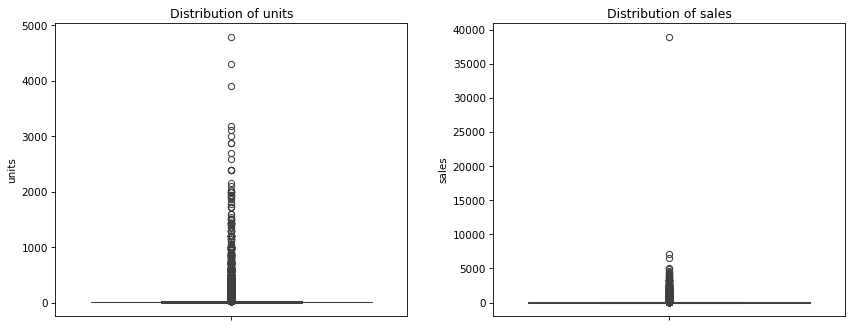

In [30]:
# Visualizing outliers
nums = df[['units', 'sales']].columns.tolist()
plt.figure(figsize=(12, 5))

for i, variable in enumerate(nums):
    plt.subplot(1, 2, i + 1)
    sns.boxplot(df[variable])
    plt.title(f'Distribution of {variable}')
plt.tight_layout(pad=3)
plt.show()

What do sales and units look like over time?

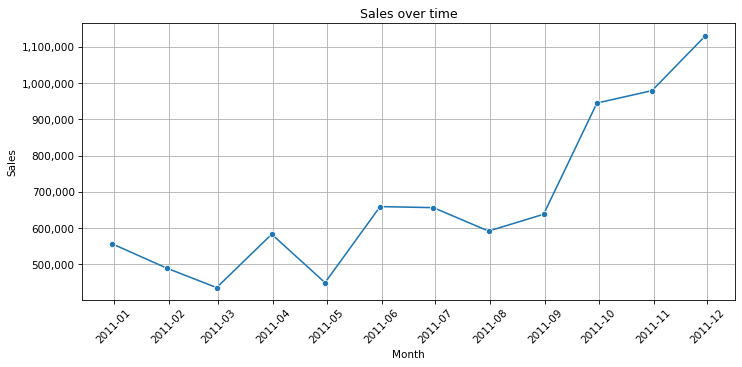

In [31]:
# Function to format y-axis without scientific notation
def human_format(x, pos):
    return f'{int(x):,}'

# date lineplot
monthly_data = df[['date', 'units', 'sales']].resample('ME', on='date').sum().reset_index()
monthly_data = monthly_data[:-1]

plt.figure(figsize=(10, 5))
sns.lineplot(x='date', y='sales', data=monthly_data, marker='o')

# Set major locator to month and formatter to show month and year
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Remove scientific notation on y-axis labels
plt.gca().yaxis.set_major_formatter(FuncFormatter(human_format))

plt.title('Sales over time')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

### RFM analysis

**Recency:** days since last customer transaction  
**Frequency:** number of transactions in the last 12 months  
**Monetary Value:** total spend in the last 12 months

In [32]:
latest_day = max(df.date) + dt.timedelta(days=1)

In [33]:
# Calculate Recency, Frequency and Monetary value for each customer 
rfm = df.groupby(['customerid']).agg({
    'date': lambda x: (latest_day - x.max()).days,
    'invoice': 'count',
    'sales': 'sum'})

# Rename columns
rfm.rename(columns = {'date': 'Recency',
                      'invoice': 'Frequency',
                      'sales': 'Monetary'}, inplace=True)
rfm.head()

,Recency,Frequency,Monetary
customerid,,,
12347,3,182,4310.00
12348,76,27,1797.24
12349,19,73,1757.55
12350,311,17,334.40
12352,37,75,1545.41


## Preprocessing

In [34]:
# Check for Near-Zero Values to ensure that there are no values extremely close to zero before the log transformation
rfm.min()

Recency      1.0
Frequency    1.0
Monetary     2.9
dtype: float64

In [35]:
# Center and scale
# Add a small constant to avoid log(0)

rfm = rfm + 1e-6
rfm_log = np.log(rfm)

scaler = StandardScaler()
scaler.fit(rfm_log)

normalized = scaler.transform(rfm_log)
rfm_scaled = pd.DataFrame(data=normalized, index=rfm.index, columns=rfm.columns)

rfm_scaled.describe().round(2)

,Recency,Frequency,Monetary
count,4334.00,4334.00,4334.00
mean,0.00,0.00,0.00
std,1.00,1.00,1.00
min,-2.75,-2.79,-4.39
25%,-0.66,-0.63,-0.68
50%,0.09,0.02,-0.06
75%,0.84,0.70,0.66
max,1.53,4.01,4.75


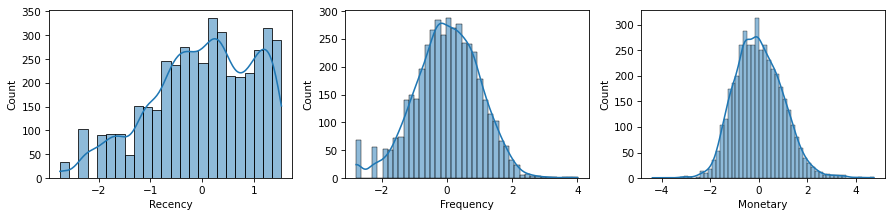

In [36]:
# Visualizing distributions after log transformations
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1); sns.histplot(rfm_scaled['Recency'], kde=True)
plt.subplot(1, 3, 2); sns.histplot(rfm_scaled['Frequency'], kde=True)
plt.subplot(1, 3, 3); sns.histplot(rfm_scaled['Monetary'], kde=True)
plt.tight_layout()
plt.show()

## Model Building

#### K-Means

In [37]:
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=10)
    kmeans.fit(rfm_scaled)
    sse[k] = kmeans.inertia_

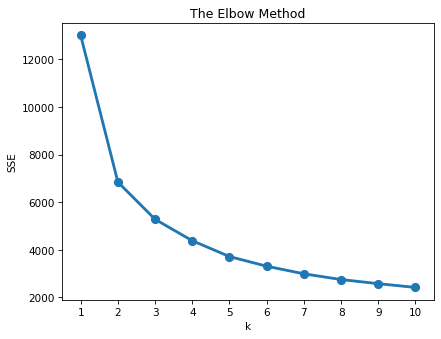

In [38]:
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

Analyze and visualize results

In [39]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=1, n_init=10)
    kmeans.fit(rfm_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.3953747346482828
For n_clusters=3, the silhouette score is 0.30422038114207794
For n_clusters=4, the silhouette score is 0.30329244070212247
For n_clusters=5, the silhouette score is 0.28028165683730627
For n_clusters=6, the silhouette score is 0.2775081225328099
For n_clusters=7, the silhouette score is 0.2672714649513879
For n_clusters=8, the silhouette score is 0.2604801343973245


* 2 clusters has the highest score but might not provide enough granularity to gain deeper insights into customer behavior
* 3 and 4 clusters are close on silhouette score, but 3 is the better choice with slightly higher score

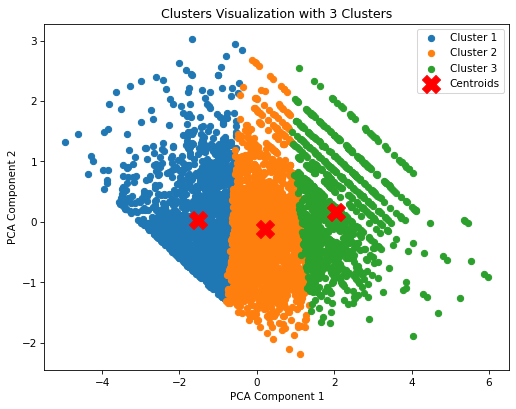

In [40]:
# Function to plot clusters
def plot_clusters(rfm_scaled, cluster_labels, centroids, n_clusters):
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(rfm_scaled)
    centroid_components = pca.transform(centroids)

    plt.figure(figsize=(8, 6))
    for i in range(n_clusters):
        plt.scatter(principal_components[cluster_labels == i, 0], 
                    principal_components[cluster_labels == i, 1], 
                    label='Cluster ' + str(i + 1))
        
    # Plot centroids
    plt.scatter(centroid_components[:, 0], centroid_components[:, 1], 
                s=300, c='red', label='Centroids', marker='X')
    
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(f'Clusters Visualization with {n_clusters} Clusters')
    plt.legend()
    plt.show()
    
# Clustering with 3 clusters
kmeans_3 = KMeans(n_clusters=3, random_state=1, n_init=10)
kmeans_3.fit(normalized)
cluster_labels_3 = kmeans_3.labels_
centroids_3 = kmeans_3.cluster_centers_

# Plot clusters
plot_clusters(normalized, cluster_labels_3, centroids_3, 3)

3 clusters in the PCA visualization reveal distinct regions with some overlap

In [41]:
# Create a copy of original rfm dataframe to preserve it
rfm_3 = rfm.copy()
rfm_3['Cluster_3'] = kmeans_3.labels_

# Analyzing cluster characteristics for 3 clusters
Cluster_summary = rfm_3.groupby('Cluster_3').mean()
print(rfm_3['Cluster_3'].value_counts())
Cluster_summary.astype('int')

Cluster_3
1    1850
0    1534
2     950
Name: count, dtype: int64


,Recency,Frequency,Monetary
Cluster_3,,,
0,172,14,293
1,67,63,1112
2,13,256,6265


## Business Insights and Recommendations

**Cluster 0** represents customers who haven't purchased in a while, as indicated by high recency, make infrequent purchases, and have low monetary value  
* These could be churned or inactive customers the company could target with a reactivation campain to re-engage them. The company could better understand these customers through surveys, then offer discounts or special offers. 

**Cluster 1** includes customers who purchased somewhat recently, make frequent purchases, and have high monetary value  
* The company could reward these customers through loyalty programs and offer personalized recommendations based on their purchasing history.

**Cluster 2** customers have made very recent purchases and are the most frequent buyers, as well as have the highest monetary value
* These are the customers to target with VIP treatment, such as dedicated customer service or exclusive offers, focusing on retention strategies to ensure they continue to feel valued and appreciated. With their high monetary value, these customers could also repond well to cross-selling or upselling techniques to introduce them to complimentary products.

### DBSCAN

*The following is a test, which did not yet achieve strong results. The eps value of 0.3 appears to be a good approximation based on the plot, but it produced 11 clusters. Therefore, 0.5 was tested to get fewer clusters, which are heavily imbalanced.*

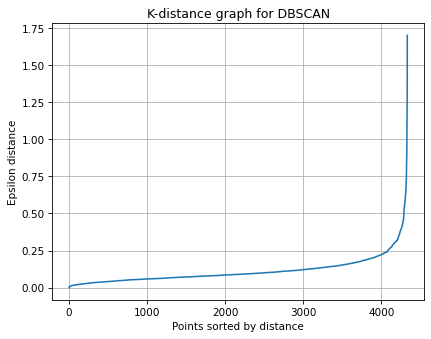

In [42]:
from sklearn.neighbors import NearestNeighbors

# Compute the k-nearest neighbors
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(rfm_scaled)
distances, indices = neighbors_fit.kneighbors(rfm_scaled)

# Sort the distances and plot the k-distance graph
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('Epsilon distance')
plt.title('K-distance graph for DBSCAN')
plt.grid(True)
plt.show()

In [43]:
# Apply DBSCAN
eps_value = 0.5
min_samples_value = 5

db = DBSCAN(eps=eps_value, min_samples=min_samples_value)
clusters = db.fit_predict(rfm_scaled)

# Add the cluster labels to the original dataframe
rfm_scaled['Cluster'] = clusters

# Display the number of clusters found
num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print(f"Number of clusters found: {num_clusters}")

# Display the first few rows of the dataframe with cluster labels
rfm_scaled.head()

Number of clusters found: 4


,Recency,Frequency,Monetary,Cluster
customerid,,,,
12347,-1.957343,1.176900,1.430777,0
12348,0.381181,-0.276992,0.733129,0
12349,-0.621839,0.480841,0.715317,0
12350,1.400672,-0.629479,-0.608168,0
12352,-0.139624,0.501435,0.612721,0


In [44]:
cluster_profile = rfm_scaled['Cluster'].value_counts()
print(cluster_profile )

Cluster
 0    4181
-1      79
 3      49
 1      17
 2       8
Name: count, dtype: int64


### Hierarchical
*Thus far, hierarchical clustering produced an excessive number of clusters as well*

In [45]:
# Perform hierarchical/agglomerative clustering
linked = linkage(rfm_scaled, method='ward')

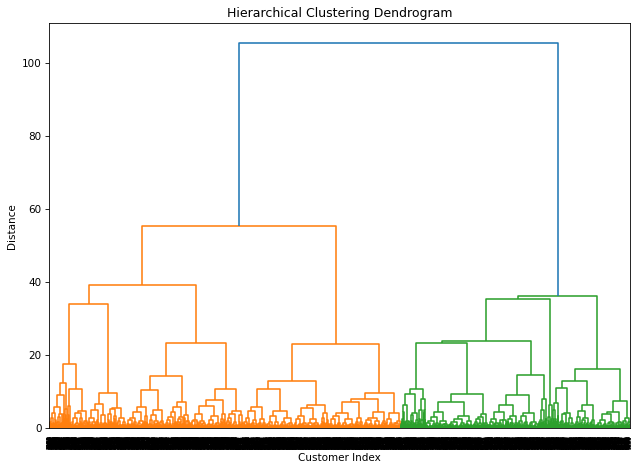

In [46]:
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Customer Index')
plt.ylabel('Distance')
plt.show()